# 对我们提取特征之后的数据重新利用神经网络进行学习

### 介绍

我们在`word_data`提取了一系列的特征，比如senti(情感标签)、cixing(词性)、diversity(词的多义性)、freq(在字典中的词频)、vowel_percentage(包含元音百分比)、if_weekdays(是否工作日)、correation(单词字母相关度),在这些特征之外，我们还加入了月份和日期作为另外的两个维度，通过一共输入维度为9、输出维度为7、两个50维隐含层的神经网络输出最终的分布值，我们将数据划分70%为训练集、剩下30%为测试集，最终在测试集上所得MSE为0.0042,且由图片可以看出预测的分布较为精准。

In [56]:
# 读取word_data.xlsx中的数据，将其转换为特征向量，然后使用简单的神经网络进行分类
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from simpleNet import SimpleNet

### 加载数据

In [57]:
# 读取数据
data = pd.read_excel('word_data_new.xlsx')
data.head()

,Date,Date.1,Contest number,word,senti,senti_score,cixing,diversity,freq_1,freq_2,vowel_percentage(%),if_weekdays,correlations,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,2022-12-31,44926,560,manly,1,0.0000,RB,0.620000,0.264214,0.265298,20.0,0,0.343806,0,2,17,37,29,12,2
1,2022-12-30,44925,559,molar,1,0.0000,JJ,0.777778,0.329989,0.315016,40.0,1,0.491583,0,4,21,38,26,9,1
2,2022-12-29,44924,558,havoc,0,-0.5994,NN,0.001000,0.254738,0.237445,40.0,1,0.097901,0,2,16,38,30,12,2
3,2022-12-28,44923,557,impel,1,0.0000,NN,0.500000,0.287625,0.314575,40.0,1,0.187709,0,3,21,40,25,9,1
4,2022-12-27,44922,556,condo,1,0.0000,NN,0.001000,0.267001,0.290084,40.0,1,0.308737,0,2,17,35,29,14,3


In [58]:
# 列出cixing的所有取值
cixing = data['cixing'].unique()
print(cixing)

['RB' 'JJ' 'NN' 'IN' 'VBD' 'VB' 'VBN' 'NNS' 'VBP' 'EX' 'NNP' 'VBZ' 'CC'
 'VBG' 'FW' 'RBR' 'JJR' 'MD' 'JJS' 'PRP$' 'DT']


In [59]:
# 将cixing的取值转换为数字
# 先制作一个map ['RB' 'JJ' 'NN' 'IN' 'VBD' 'VB' 'VBN' 'NNS' 'VBP' 'EX' 'NNP' 'VBZ' 'CC' 'VBG' 'FW' 'RBR' 'JJR' 'MD' 'JJS' 'PRP$' 'DT']
cixing_map = {'RB': 0, 'JJ': 1, 'NN': 2, 'IN': 3, 'VBD': 4, 'VB': 5, 'VBN': 6, 'NNS': 7, 'VBP': 8, 'EX': 9, 'NNP': 10, 'VBZ': 11, 'CC': 12, 'VBG': 13, 'FW': 14, 'RBR': 15, 'JJR': 16, 'MD': 17, 'JJS': 18, 'PRP$': 19, 'DT': 20}
data['cixing'] = data['cixing'].map(cixing_map)
print(data['cixing'].unique())


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [60]:
data.head()

,Date,Date.1,Contest number,word,senti,senti_score,cixing,diversity,freq_1,freq_2,vowel_percentage(%),if_weekdays,correlations,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,2022-12-31,44926,560,manly,1,0.0000,0,0.620000,0.264214,0.265298,20.0,0,0.343806,0,2,17,37,29,12,2
1,2022-12-30,44925,559,molar,1,0.0000,1,0.777778,0.329989,0.315016,40.0,1,0.491583,0,4,21,38,26,9,1
2,2022-12-29,44924,558,havoc,0,-0.5994,2,0.001000,0.254738,0.237445,40.0,1,0.097901,0,2,16,38,30,12,2
3,2022-12-28,44923,557,impel,1,0.0000,2,0.500000,0.287625,0.314575,40.0,1,0.187709,0,3,21,40,25,9,1
4,2022-12-27,44922,556,condo,1,0.0000,2,0.001000,0.267001,0.290084,40.0,1,0.308737,0,2,17,35,29,14,3


In [61]:
# 删除不需要的列 senti_score, freq_1
data = data.drop(['senti_score', 'freq_1','Date.1'], axis=1)

In [62]:
data.head()

,Date,Contest number,word,senti,cixing,diversity,freq_2,vowel_percentage(%),if_weekdays,correlations,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,2022-12-31,560,manly,1,0,0.620000,0.265298,20.0,0,0.343806,0,2,17,37,29,12,2
1,2022-12-30,559,molar,1,1,0.777778,0.315016,40.0,1,0.491583,0,4,21,38,26,9,1
2,2022-12-29,558,havoc,0,2,0.001000,0.237445,40.0,1,0.097901,0,2,16,38,30,12,2
3,2022-12-28,557,impel,1,2,0.500000,0.314575,40.0,1,0.187709,0,3,21,40,25,9,1
4,2022-12-27,556,condo,1,2,0.001000,0.290084,40.0,1,0.308737,0,2,17,35,29,14,3


In [63]:
# 构造输入输出数据
data_features = data.iloc[:,[0,3,4,5,6,7,8,9]]
data_distribution = data.iloc[:,10:]

In [64]:
data_features.head()

,Date,senti,cixing,diversity,freq_2,vowel_percentage(%),if_weekdays,correlations
0,2022-12-31,1,0,0.620000,0.265298,20.0,0,0.343806
1,2022-12-30,1,1,0.777778,0.315016,40.0,1,0.491583
2,2022-12-29,0,2,0.001000,0.237445,40.0,1,0.097901
3,2022-12-28,1,2,0.500000,0.314575,40.0,1,0.187709
4,2022-12-27,1,2,0.001000,0.290084,40.0,1,0.308737


In [65]:
data_distribution.head()

,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
0,0,2,17,37,29,12,2
1,0,4,21,38,26,9,1
2,0,2,16,38,30,12,2
3,0,3,21,40,25,9,1
4,0,2,17,35,29,14,3


### 删除一些feature

In [66]:
# 删除不需要的列
# data_features = data_features.drop(['cixing','senti'], axis=1)
data_features.head()

,Date,senti,cixing,diversity,freq_2,vowel_percentage(%),if_weekdays,correlations
0,2022-12-31,1,0,0.620000,0.265298,20.0,0,0.343806
1,2022-12-30,1,1,0.777778,0.315016,40.0,1,0.491583
2,2022-12-29,0,2,0.001000,0.237445,40.0,1,0.097901
3,2022-12-28,1,2,0.500000,0.314575,40.0,1,0.187709
4,2022-12-27,1,2,0.001000,0.290084,40.0,1,0.308737


### 转换数据

In [67]:
# 将data_features第一列数据分成两列 即将Date列分成月和日两列
data_features['Month'] = data_features['Date'].apply(lambda x: x.month)
data_features['Day'] = data_features['Date'].apply(lambda x: x.day)
data_features = data_features.drop(['Date'], axis=1)
data_features.head()

C:\Users\dongl\AppData\Local\Temp/ipykernel_6024/1307404672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features['Month'] = data_features['Date'].apply(lambda x: x.month)
C:\Users\dongl\AppData\Local\Temp/ipykernel_6024/1307404672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features['Day'] = data_features['Date'].apply(lambda x: x.day)


,senti,cixing,diversity,freq_2,vowel_percentage(%),if_weekdays,correlations,Month,Day
0,1,0,0.620000,0.265298,20.0,0,0.343806,12,31
1,1,1,0.777778,0.315016,40.0,1,0.491583,12,30
2,0,2,0.001000,0.237445,40.0,1,0.097901,12,29
3,1,2,0.500000,0.314575,40.0,1,0.187709,12,28
4,1,2,0.001000,0.290084,40.0,1,0.308737,12,27


In [68]:
# 转换数据格式
data_features_np = data_features.values
data_distribution_np = data_distribution.values
print('data_features_np.shape = ', data_features_np.shape)
print('data_features_np[:5,:] = \n', data_features_np[:5,:])
print('data_distribution_np.shape = ', data_distribution_np.shape)
print('data_distribution_np[:5,:] = \n', data_distribution_np[:5,:])

data_features_np.shape =  (359, 9)
data_features_np[:5,:] = 
 [[1.00000000e+00 0.00000000e+00 6.20000000e-01 2.65297965e-01
  2.00000000e+01 0.00000000e+00 3.43805514e-01 1.20000000e+01
  3.10000000e+01]
 [1.00000000e+00 1.00000000e+00 7.77777778e-01 3.15016189e-01
  4.00000000e+01 1.00000000e+00 4.91582513e-01 1.20000000e+01
  3.00000000e+01]
 [0.00000000e+00 2.00000000e+00 1.00000000e-03 2.37445032e-01
  4.00000000e+01 1.00000000e+00 9.79006807e-02 1.20000000e+01
  2.90000000e+01]
 [1.00000000e+00 2.00000000e+00 5.00000000e-01 3.14574926e-01
  4.00000000e+01 1.00000000e+00 1.87708873e-01 1.20000000e+01
  2.80000000e+01]
 [1.00000000e+00 2.00000000e+00 1.00000000e-03 2.90084013e-01
  4.00000000e+01 1.00000000e+00 3.08737246e-01 1.20000000e+01
  2.70000000e+01]]
data_distribution_np.shape =  (359, 7)
data_distribution_np[:5,:] = 
 [[ 0  2 17 37 29 12  2]
 [ 0  4 21 38 26  9  1]
 [ 0  2 16 38 30 12  2]
 [ 0  3 21 40 25  9  1]
 [ 0  2 17 35 29 14  3]]


In [69]:
# 做数据处理
# 对data_features_np进行normalization
features_mean = np.mean(data_features_np, axis=0)
features_std = np.std(data_features_np, axis=0)
data_features_np_norm = (data_features_np - features_mean) / features_std
# 将data_distribution_np中的数据转换为概率分布
data_distribution_np = data_distribution_np / 100
print('data_features_np_norm[:5,:] = \n', data_features_np_norm[:5,:])
print('data_distribution_np[:5,:] = \n', data_distribution_np[:5,:])

data_features_np_norm[:5,:] = 
 [[ 0.06666118 -0.86473559  0.30348369 -0.51696379 -1.27981959 -1.57652685
  -0.04498888  1.58231754  1.72832776]
 [ 0.06666118 -0.55827944  0.8165452   0.36174245  0.34561166  0.63430572
   0.41264337  1.58231754  1.61368074]
 [-2.59237924 -0.25182329 -1.70937944 -1.0092289   0.34561166  0.63430572
  -0.80650105  1.58231754  1.49903372]
 [ 0.06666118 -0.25182329 -0.0867321   0.35394368  0.34561166  0.63430572
  -0.52838521  1.58231754  1.3843867 ]
 [ 0.06666118 -0.25182329 -1.70937944 -0.07890199  0.34561166  0.63430572
  -0.15358745  1.58231754  1.26973968]]
data_distribution_np[:5,:] = 
 [[0.   0.02 0.17 0.37 0.29 0.12 0.02]
 [0.   0.04 0.21 0.38 0.26 0.09 0.01]
 [0.   0.02 0.16 0.38 0.3  0.12 0.02]
 [0.   0.03 0.21 0.4  0.25 0.09 0.01]
 [0.   0.02 0.17 0.35 0.29 0.14 0.03]]


### 划分数据集

In [70]:
# 将数据转换为tensor，并用device指定运行的设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = ', device)
data_features_tensor = torch.tensor(data_features_np_norm, dtype=torch.float32, device=device)
data_distribution_tensor = torch.tensor(data_distribution_np, dtype=torch.float32, device=device)

device =  cpu


In [71]:
print('data_features_tensor.shape = ', data_features_tensor.shape)
print('data_features_tensor[:5,:] = \n', data_features_tensor[:5,:])
print('data_distribution_tensor.shape = ', data_distribution_tensor.shape)
print('data_distribution_tensor[:5,:] = \n', data_distribution_tensor[:5,:])

data_features_tensor.shape =  torch.Size([359, 9])
data_features_tensor[:5,:] = 
 tensor([[ 0.0667, -0.8647,  0.3035, -0.5170, -1.2798, -1.5765, -0.0450,  1.5823,
          1.7283],
        [ 0.0667, -0.5583,  0.8165,  0.3617,  0.3456,  0.6343,  0.4126,  1.5823,
          1.6137],
        [-2.5924, -0.2518, -1.7094, -1.0092,  0.3456,  0.6343, -0.8065,  1.5823,
          1.4990],
        [ 0.0667, -0.2518, -0.0867,  0.3539,  0.3456,  0.6343, -0.5284,  1.5823,
          1.3844],
        [ 0.0667, -0.2518, -1.7094, -0.0789,  0.3456,  0.6343, -0.1536,  1.5823,
          1.2697]])
data_distribution_tensor.shape =  torch.Size([359, 7])
data_distribution_tensor[:5,:] = 
 tensor([[0.0000, 0.0200, 0.1700, 0.3700, 0.2900, 0.1200, 0.0200],
        [0.0000, 0.0400, 0.2100, 0.3800, 0.2600, 0.0900, 0.0100],
        [0.0000, 0.0200, 0.1600, 0.3800, 0.3000, 0.1200, 0.0200],
        [0.0000, 0.0300, 0.2100, 0.4000, 0.2500, 0.0900, 0.0100],
        [0.0000, 0.0200, 0.1700, 0.3500, 0.2900, 0.1400, 0.0300

In [72]:
# 划分训练集和测试集
train_size = int(0.7 * data_features_tensor.shape[0])
print('train_size = ', train_size)

train_size =  251


In [73]:
# 先将数据打乱
indices = torch.randperm(data_features_tensor.shape[0])
data_features_tensor = data_features_tensor[indices]
data_distribution_tensor = data_distribution_tensor[indices]

In [74]:
test_indices = indices[train_size:]
test_indices = test_indices.cpu().numpy()

In [75]:
# 划分训练集和测试集
train_features = data_features_tensor[:train_size,:]
train_distribution = data_distribution_tensor[:train_size,:]
test_features = data_features_tensor[train_size:,:]
test_distribution = data_distribution_tensor[train_size:,:]

print('train_features.shape = ', train_features.shape)
print('train_distribution.shape = ', train_distribution.shape)
print('test_features.shape = ', test_features.shape)
print('test_distribution.shape = ', test_distribution.shape)


train_features.shape =  torch.Size([251, 9])
train_distribution.shape =  torch.Size([251, 7])
test_features.shape =  torch.Size([108, 9])
test_distribution.shape =  torch.Size([108, 7])


In [76]:
# 制作dataloader
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(train_features, train_distribution)
test_dataset = torch.utils.data.TensorDataset(test_features, test_distribution)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 网络参数

In [77]:
inp_dim = 9
hidden_dim = 50
out_dim = 7

In [78]:
net = SimpleNet(inp_dim, hidden_dim, out_dim).to(device)

In [79]:
summary(net, (batch_size,inp_dim))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleNet                                [64, 7]                   --
├─Linear: 1-1                            [64, 50]                  500
├─Linear: 1-2                            [64, 50]                  2,550
├─Linear: 1-3                            [64, 7]                   357
├─Softmax: 1-4                           [64, 7]                   --
Total params: 3,407
Trainable params: 3,407
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.07

In [80]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

### 开始训练

In [81]:
# 训练
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-7)
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
num_epochs = 500
train_loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    net.train()
    for i, (features, distribution) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(features)
        loss = criterion(output, distribution)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / train_size
    train_loss_list.append(train_loss)
    net.eval()
    with torch.no_grad():
        for i, (features, distribution) in enumerate(test_loader):
            output = net(features)
            loss = criterion(output, distribution)
            test_loss += loss.item()
    test_loss = test_loss / (359 - train_size)
    test_loss_list.append(test_loss)
    if (epoch + 1) % 20 == 0:
        print('Epoch [{:4d}/{:4d}], Train Loss: {:.6f}, Test Loss: {:.6f}'.format(epoch + 1, num_epochs, train_loss_list[-1], test_loss_list[-1]))

Epoch [  20/ 500], Train Loss: 0.000044, Test Loss: 0.000059
Epoch [  40/ 500], Train Loss: 0.000042, Test Loss: 0.000056
Epoch [  60/ 500], Train Loss: 0.000040, Test Loss: 0.000053
Epoch [  80/ 500], Train Loss: 0.000039, Test Loss: 0.000051
Epoch [ 100/ 500], Train Loss: 0.000037, Test Loss: 0.000049
Epoch [ 120/ 500], Train Loss: 0.000037, Test Loss: 0.000048
Epoch [ 140/ 500], Train Loss: 0.000036, Test Loss: 0.000047
Epoch [ 160/ 500], Train Loss: 0.000037, Test Loss: 0.000046
Epoch [ 180/ 500], Train Loss: 0.000036, Test Loss: 0.000046
Epoch [ 200/ 500], Train Loss: 0.000036, Test Loss: 0.000046
Epoch [ 220/ 500], Train Loss: 0.000036, Test Loss: 0.000046
Epoch [ 240/ 500], Train Loss: 0.000036, Test Loss: 0.000045
Epoch [ 260/ 500], Train Loss: 0.000035, Test Loss: 0.000046
Epoch [ 280/ 500], Train Loss: 0.000035, Test Loss: 0.000045
Epoch [ 300/ 500], Train Loss: 0.000035, Test Loss: 0.000045
Epoch [ 320/ 500], Train Loss: 0.000035, Test Loss: 0.000045
Epoch [ 340/ 500], Train

### 训练过程loss-epoch曲线

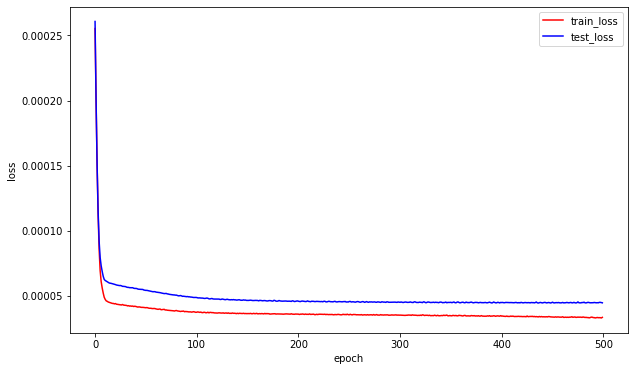

In [82]:
# 画图
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='train_loss', color='r')
plt.plot(test_loss_list, label='test_loss', color='b')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [83]:
min(test_loss_list)

4.4470891158130985e-05

### 保存模型

In [84]:
# 保存模型
# torch.save(net.state_dict(), 'model_useFeatures.pth')

### 加载模型与评估

In [85]:
# # 加载模型
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# net = SimpleNet(inp_dim, hidden_dim, out_dim).to(device)
# net.load_state_dict(torch.load('model_useFeatures.pth'))

In [86]:
# 从test_features中随机抽取一个样本

In [87]:
def mseloss(y_pred, y):
    return np.mean((y_pred - y)**2)

output_np = 
 [[0.00444048 0.04392627 0.20513156 0.3454996  0.25986338 0.11537538
  0.02576329]]
test_distribution_np[idx,:] = 
 [0.   0.03 0.19 0.35 0.29 0.13 0.02]
criterion:  tensor(0.0002)
mseloss:  0.0002311696


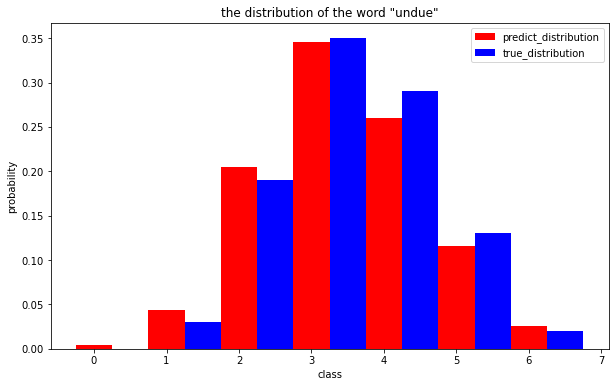

In [88]:
idx = np.random.randint(0, test_features.shape[0])
# 找出该样本对应的单词
right_idx = test_indices[idx]
word = data['word'][right_idx]
# 推理
net.eval()
with torch.no_grad():
    output = net(test_features[idx,:].unsqueeze(0))
    output_np = output.cpu().numpy()
    print('output_np = \n', output_np)
    print('test_distribution_np[idx,:] = \n', test_distribution[idx,:].cpu().numpy())
    print('criterion: ', criterion(output, test_distribution[idx,:].unsqueeze(0)))
    print('mseloss: ', mseloss(output_np, test_distribution[idx,:].cpu().numpy()))
    # 画图
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(7), output_np[0], width=0.5, label='predict_distribution', color='r')
    plt.bar(np.arange(7)+0.5,  test_distribution[idx,:].cpu().numpy() , width=0.5, label='true_distribution', color='b')
    plt.xlabel('class')
    plt.ylabel('probability')
    plt.title('the distribution of the word "{}"'.format(word))
    plt.savefig('distribution_of_{}.png'.format(word))
    plt.legend()
    plt.show()

### 测试集总体的mse

In [89]:
# 求测试集总体的mse
with torch.no_grad():
    mse_sum = 0
    for idx in range(0, test_features.shape[0]):
        output = net(test_features[idx,:].unsqueeze(0))
        output_np = output.cpu().numpy()
        mse_sum += mseloss(output_np, test_distribution[idx,:].cpu().numpy())
    print('mse_sum = ', mse_sum)

mse_sum =  0.24923802075136336


In [94]:
test_features.shape[0]

108

#### 单词eerie的分布

<!-- 表格 -->

| word | date | if_weekday | senti | cixing | diversity | freq        | vowel percentage(%) | correlations       |
|:-----|:-----|:-----------|:------|:-------|:----------|:------------|:--------------------|:-------------------|
| eerie| 0    | 0/1        | 1     | NN(2)  | 0.444444  | 0.482179277 | 80                  | 1.4018470349381116 |

In [90]:
data_features.head()

,senti,cixing,diversity,freq_2,vowel_percentage(%),if_weekdays,correlations,Month,Day
0,1,0,0.620000,0.265298,20.0,0,0.343806,12,31
1,1,1,0.777778,0.315016,40.0,1,0.491583,12,30
2,0,2,0.001000,0.237445,40.0,1,0.097901,12,29
3,1,2,0.500000,0.314575,40.0,1,0.187709,12,28
4,1,2,0.001000,0.290084,40.0,1,0.308737,12,27


In [91]:
# data_eerie_np = np.array([1,0.4444444,0.482179277,80,0,1.4018470349381116]) # 删掉了cixing
# data_eerie_np = np.array([0.4444444,0.482179277,80,0,1.4018470349381116]) # 删掉了cixing 和 senti
data_eerie_np = np.array([1, 2, 0.4444444,0.482179277,80,0,1.4018470349381116,3,1])

In [92]:
# 将数据转换为tensor，并用device指定运行的设备
data_eerie_np = (data_eerie_np - features_mean) / features_std
data_eerie_tensor = torch.tensor(data_eerie_np, dtype=torch.float32, device=device)

output_np = 
 [[0.00540953 0.07753994 0.22494373 0.30244526 0.25199705 0.10762829
  0.03003615]]


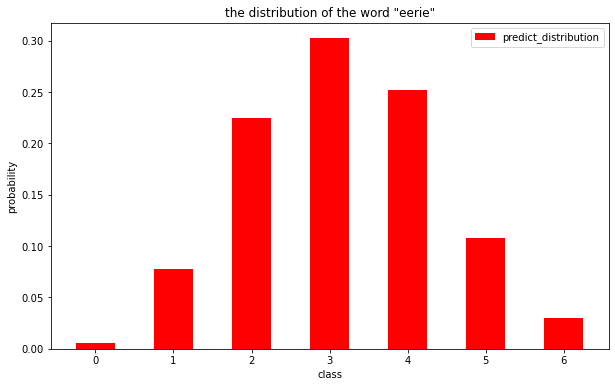

In [93]:

# 推理
net.eval()
with torch.no_grad():
    output = net(data_eerie_tensor.unsqueeze(0))
    output_np = output.cpu().numpy()
    print('output_np = \n', output_np)
    # 画图
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(7), output_np[0], width=0.5, label='predict_distribution', color='r')
    plt.xlabel('class')
    plt.ylabel('probability')
    plt.title('the distribution of the word "{}"'.format('eerie'))
    plt.savefig('distribution_of_{}.png'.format('eerie'))
    plt.legend()
    plt.show()

In [96]:
output_np.sum()

0.99999994